1. [Prepare data](#Prepare-data)
    1. [Enriching data](#Enriching-data(only-for-binding-version1-and-version2-of-the-dataset))
1. [(Right way) reading data](#(Right-way)-reading-data)

In [2]:
import re
import json
import surprise
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# ! ls ./data

In [3]:
import gc
gc.collect()

19

## Prepare data
As I found this user_item json data have a problems with quotes and parsing. Therefore I modify names of some games.

In [22]:
user_item = []
with open("./data/australian_users_items.json") as f:
    s = "[" + f.read().strip() + "]"
    s = s.replace("\\", ' ')
    s = s.replace('"Glow Ball"', 'Glow Ball')
    s = s.replace('"New life"', "New life")
    double = set(re.findall(r'"[^"]+"', s))
    for x in tqdm(double):
        tmp = x.replace("'", " ")
        tmp = tmp.replace('"', "'")
        s = s.replace(x, tmp)
    s = s.replace("\n", ",\n")
    s = s.replace("'", '"')
    s = s.replace('"One pioneer  s story"', 'One pioneer  s story')
    user_item = json.loads(s)

In [15]:
with open("./data/fixed_australian_users_items.json", 'w') as f:
    json.dump(user_item, f)

In [5]:
with open("./data/fixed_australian_users_items.json") as f:
    user_item = json.loads(f.read())

In [11]:
user_item[10]

{'user_id': 'corrupted_soul',
 'items_count': 115,
 'steam_id': '76561198007659921',
 'user_url': 'http://steamcommunity.com/id/corrupted_soul',
 'items': [{'item_id': '4000',
   'item_name': 'Garry s Mod',
   'playtime_forever': 2644,
   'playtime_2weeks': 0},
  {'item_id': '1250',
   'item_name': 'Killing Floor',
   'playtime_forever': 30266,
   'playtime_2weeks': 0},
  {'item_id': '35420',
   'item_name': 'Killing Floor Mod: Defence Alliance 2',
   'playtime_forever': 54,
   'playtime_2weeks': 0},
  {'item_id': '6060',
   'item_name': 'STAR WARS™ Battlefront™ II',
   'playtime_forever': 86,
   'playtime_2weeks': 0},
  {'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_forever': 108,
   'playtime_2weeks': 0},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '40',
   'item_name': 'Deathmatch

### Enriching data(only for binding version1 and version2 of the dataset)
Steam users can change their nicknames and we should scrape aliases(that saved by Steam and it is in the public domain)
<img src="../images/steam_aliases.png">

(Also) we can ping Steam for actual game name because we modify game names and some games changed their names(for example, [NotGTAV](https://store.steampowered.com/app/369580/NotTheNameWeWanted/))

In [24]:
from tqdm import tqdm
item_map = {}
user_info = {}
for x in tqdm(user_item):
    items = x['items']
    user = {k: v for k, v in x.items() if 'user' in k or 'steam' in k}
    user_info[x['user_id']] = user
    for item in items:
        if item['item_id'] not in item_map:
            item_map[item['item_id']] = item['item_name']

100%|██████████| 88310/88310 [00:00<00:00, 105224.53it/s]


In [18]:
with open("./data/item_map.json", 'w') as f:
    json.dump(item_map, f)

In [25]:
with open("./data/user_info.json", 'w') as f:
    json.dump(user_info, f)

In [2]:
with open("./data/error_urls.json") as f:
    error_urls = json.loads(f.read())

In [3]:
len(error_urls)

1721

In [4]:
with open("./data/user_idx_aliases.json") as f:
    aliases = json.loads(f.read())

In [10]:
len(aliases)

16753

In [22]:
aliases['corrupted_soul'], aliases['76561198070181565']

(['¤Corrupted§oul¤'], ['ZuK3', 'EPICBOOFA', 'ZuK3'])

Okey, ~5 hours of scraping give us only 17000 urls.
<br>
Let's try to make some recommender system with this data

## (Right way) reading data

In [4]:
import gzip
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

In [5]:
%%time
reviews = list(parse("./data/australian_user_reviews.json.gz"))
user_items = list(parse("./data/australian_users_items.json.gz"))
# games = list(parse("./data/steam_games.json.gz")))

CPU times: user 1min 2s, sys: 1.31 s, total: 1min 4s
Wall time: 1min 5s


In [6]:
user_items[0]

{'user_id': '76561197970982479',
 'items_count': 277,
 'steam_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'items': [{'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_forever': 6,
   'playtime_2weeks': 0},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_forever': 7,
   'playtime_2weeks': 0},
  {'item_id': '40',
   'item_name': 'Deathmatch Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '50',
   'item_name': 'Half-Life: Opposing Force',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '60',
   'item_name': 'Ricochet',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '70',
   'item_name': 'Half-Life',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '130',
   'item_name': 'Half-Life: Blue Shift',
   'playtime_forever

In [7]:
import pandas as pd
from tqdm import tqdm

user_items_df = []
for u in tqdm(user_items):
    items = u['items']
    for item in items:
        tmp = [u['user_id'], item['item_id'], item['item_name'], item['playtime_forever'], item['playtime_2weeks']]
        user_items_df.append(tmp)
user_items_df = pd.DataFrame.from_records(user_items_df)
user_items_df.columns = ['user_id', 'item_id', 'item_name', 'playtime_forever', 'playtime_2weeks']
user_items_df.head()

100%|██████████| 88310/88310 [00:09<00:00, 9579.30it/s] 


,user_id,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,10,Counter-Strike,6,0
1,76561197970982479,20,Team Fortress Classic,0,0
2,76561197970982479,30,Day of Defeat,7,0
3,76561197970982479,40,Deathmatch Classic,0,0
4,76561197970982479,50,Half-Life: Opposing Force,0,0


In [8]:
user_items_df['playtime_forever'].dtype

dtype('int64')

In [65]:
import pickle
with open("./data/user_enum.pkl", 'wb') as f:
    pickle.dump({x: i for i, x in enumerate(user_items_df['user_id'].unique())}, f)

In [9]:
import pickle
with open("./data/user_enum.pkl", 'rb') as f:
    user_idxs = pickle.load(f)

In [10]:
user_items_df['user_idx'] = user_items_df['user_id'].map(user_idxs)
user_items_df['item_id'] = user_items_df['item_id'].apply(int)

In [11]:
user_items_df['user_idx'].dtype, user_items_df['item_id'].dtype

(dtype('int64'), dtype('int64'))

In [78]:
user_items_df.to_csv("./data/user_items_df.csv", index=False)

### Reading again

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

user_items_df = pd.read_csv("./data/user_items_df.csv")
user_items_df.head()

,user_id,item_id,item_name,playtime_forever,playtime_2weeks,user_idx
0,76561197970982479,10,Counter-Strike,6,0,0
1,76561197970982479,20,Team Fortress Classic,0,0,0
2,76561197970982479,30,Day of Defeat,7,0,0
3,76561197970982479,40,Deathmatch Classic,0,0,0
4,76561197970982479,50,Half-Life: Opposing Force,0,0,0


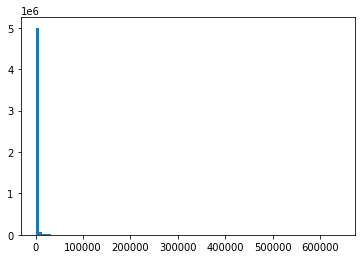

In [13]:
plt.hist(user_items_df['playtime_forever'], bins=100);

In [14]:
user_items_df[user_items_df['playtime_forever'] > 600000]

,user_id,item_id,item_name,playtime_forever,playtime_2weeks,user_idx
587715,wolop,4000,Garry's Mod,642773,7299,5263
1495340,76561198039832932,4000,Garry's Mod,613411,588,13044
1836985,tsunamitad,72200,Universe Sandbox,600068,0,15767
2499068,Evilutional,212200,Mabinogi,635295,0,22736
4075729,76561198019826668,42710,Call of Duty: Black Ops - Multiplayer,632452,8126,40042


In [15]:
user_items_df[user_items_df['playtime_forever'] < 1000]

,user_id,item_id,item_name,playtime_forever,playtime_2weeks,user_idx
0,76561197970982479,10,Counter-Strike,6,0,0
1,76561197970982479,20,Team Fortress Classic,0,0,0
2,76561197970982479,30,Day of Defeat,7,0,0
3,76561197970982479,40,Deathmatch Classic,0,0,0
4,76561197970982479,50,Half-Life: Opposing Force,0,0,0
...,...,...,...,...,...,...
5153204,76561198329548331,346330,BrainBread 2,0,0,70911
5153205,76561198329548331,373330,All Is Dust,0,0,70911
5153206,76561198329548331,388490,One Way To Die: Steam Edition,3,3,70911
5153207,76561198329548331,521570,You Have 10 Seconds 2,4,4,70911


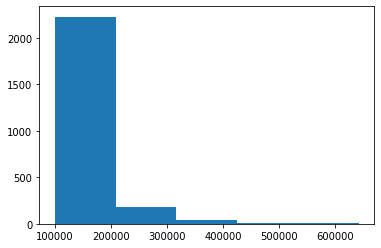

In [16]:
plt.hist(user_items_df['playtime_forever'][user_items_df['playtime_forever'] > 100000], bins=5);

In [17]:
user_items_df['rating'] = pd.qcut(user_items_df['playtime_forever'], q=7, duplicates='drop')

In [18]:
user_items_df['rating'].dtype

CategoricalDtype(categories=[(-0.001, 10.0], (10.0, 76.0], (76.0, 264.0], (264.0, 956.0], (956.0, 642773.0]],
, ordered=True)

In [19]:
sorted(user_items_df['rating'].unique())

[Interval(-0.001, 10.0, closed='right'),
 Interval(10.0, 76.0, closed='right'),
 Interval(76.0, 264.0, closed='right'),
 Interval(264.0, 956.0, closed='right'),
 Interval(956.0, 642773.0, closed='right')]

In [20]:
d = {
    pd.Interval(-0.001, 10.0, closed='right'): 1,
    pd.Interval(10.0, 76.0, closed='right'): 2,
    pd.Interval(76.0, 264.0, closed='right'): 3,
    pd.Interval(264.0, 956.0, closed='right'): 4,
    pd.Interval(956.0, 642773.0, closed='right'): 5,
}
user_items_df['rating'] = user_items_df['rating'].map(d)

In [21]:
df = user_items_df[['user_id', 'item_id', 'rating']]
df.columns = ['user', 'item', 'rating']
df.head()

,user,item,rating
0,76561197970982479,10,1
1,76561197970982479,20,1
2,76561197970982479,30,1
3,76561197970982479,40,1
4,76561197970982479,50,1


In [22]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, random_state=7, shuffle=True, stratify=df['rating'], test_size=0.2)

In [23]:
from surprise import Reader
from surprise.dataset import Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(train_df, reader)

In [24]:
from surprise.model_selection import RepeatedKFold
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

In [25]:
%%time
from surprise import NormalPredictor
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.model_selection import cross_validate
cross_validate(NormalPredictor(), data, cv=cv, n_jobs=10)

CPU times: user 3min 45s, sys: 7.52 s, total: 3min 52s
Wall time: 4min 2s


{'test_rmse': array([1.93805482, 1.93784713, 1.93748504, 1.93652402, 1.93522912,
        1.93606416, 1.9352901 , 1.93430942, 1.93528543, 1.93696718,
        1.93641162, 1.93549964, 1.93898673, 1.93481027, 1.93542791]),
 'test_mae': array([1.5608916 , 1.56142302, 1.56014273, 1.55965168, 1.5577934 ,
        1.55835514, 1.5579386 , 1.55731952, 1.55819045, 1.55992034,
        1.5590916 , 1.55805761, 1.56073451, 1.55758372, 1.55793254]),
 'fit_time': (3.3393940925598145,
  3.4746811389923096,
  3.515634298324585,
  3.459764003753662,
  3.4125256538391113,
  3.6442434787750244,
  3.446119546890259,
  3.6189093589782715,
  3.443687915802002,
  3.712707757949829,
  3.43514347076416,
  3.581423759460449,
  3.387056350708008,
  3.5213136672973633,
  3.5286495685577393),
 'test_time': (8.52217411994934,
  8.818690776824951,
  10.055737018585205,
  9.010737657546997,
  9.42139720916748,
  9.374121904373169,
  9.09372615814209,
  9.228681325912476,
  9.211049795150757,
  9.703021049499512,
  8.7625

In [26]:
%%time
from surprise import NormalPredictor
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise.model_selection import cross_validate

cross_validate(CoClustering(n_cltr_i=7, n_cltr_u=9, n_epochs=100), data, cv=cv, n_jobs=10)

CPU times: user 4min 44s, sys: 7.08 s, total: 4min 52s
Wall time: 12min 49s


{'test_rmse': array([1.12916861, 1.13703772, 1.14105833, 1.14069014, 1.13904835,
        1.14152988, 1.13283106, 1.12936757, 1.13731953, 1.13695978,
        1.12863643, 1.13386792, 1.124638  , 1.13289108, 1.13707833]),
 'test_mae': array([0.84624087, 0.85973893, 0.85281381, 0.86047769, 0.86012797,
        0.86067853, 0.84958667, 0.84552506, 0.84989608, 0.85963668,
        0.84659963, 0.84791789, 0.84357776, 0.85063496, 0.85923478]),
 'fit_time': (342.12411165237427,
  360.45091104507446,
  353.891902923584,
  360.2135548591614,
  366.3185954093933,
  370.46849036216736,
  365.7883279323578,
  370.5102951526642,
  369.21600818634033,
  371.6906805038452,
  268.71971321105957,
  269.35492968559265,
  261.3463213443756,
  260.79712295532227,
  257.71552658081055),
 'test_time': (11.705258131027222,
  11.468275547027588,
  11.629657745361328,
  12.00761365890503,
  12.117835760116577,
  12.153318643569946,
  13.261596918106079,
  12.782971620559692,
  10.975536823272705,
  9.82392787933349

In [27]:
%%time
from surprise import NormalPredictor
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.model_selection import cross_validate

cross_validate(NMF(), data, cv=cv, n_jobs=10)

CPU times: user 4min 35s, sys: 8.4 s, total: 4min 44s
Wall time: 9min 45s


{'test_rmse': array([1.1059869 , 1.10993355, 1.10785922, 1.10499305, 1.1051057 ,
        1.10692481, 1.10391208, 1.10632021, 1.1092128 , 1.10826693,
        1.10543819, 1.1065201 , 1.10523576, 1.10676043, 1.10783114]),
 'test_mae': array([0.83554189, 0.84068172, 0.83908809, 0.8346674 , 0.83556078,
        0.83604647, 0.83283563, 0.83582393, 0.8391608 , 0.83909088,
        0.83580863, 0.83621889, 0.83462611, 0.83667553, 0.83804942]),
 'fit_time': (227.61752152442932,
  234.51426696777344,
  234.2946650981903,
  243.76780366897583,
  249.07260990142822,
  253.25221276283264,
  260.417409658432,
  255.65384531021118,
  261.6103458404541,
  253.95248126983643,
  198.56240272521973,
  193.59674382209778,
  187.60824537277222,
  186.094961643219,
  183.28584241867065),
 'test_time': (11.76300835609436,
  14.020108938217163,
  14.383681297302246,
  11.794813871383667,
  13.457939863204956,
  12.812854528427124,
  12.207553625106812,
  12.658202886581421,
  11.459920883178711,
  11.29932665824

In [28]:
# %%time
# from surprise import NormalPredictor
# from surprise.prediction_algorithms.knns import KNNWithMeans
# from surprise.prediction_algorithms.matrix_factorization import NMF, SVDpp
# from surprise.model_selection import cross_validate

# cross_validate(SVDpp(), data, cv=cv, n_jobs=7)

In [29]:
import gc
gc.collect()

327